In [39]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd


In [40]:
# Instrument / geometry constants (SI units)
nprim = 400
nsec = 500
Lprim = 0.042  # m
Lprim_error = 0.001  # m (unused but kept for record)
Ri = 32680
Ri_error = 10
C_val = 97.8e-9
C_val_error = 0.1e-9
R_prim = 2
mu_0 = 4e-7 * np.pi

# Cross-sectional areas (mm^2)
material_area_mm2 = {
    "transformer_iron": 2.4,
    "mild_steel": 7.65,
    "copper_alloy": 19.6,
}

# Optional measurement uncertainties (unused but preserved)
material_area_error_mm2 = {
    "transformer_iron": 0.016,
    "mild_steel": 0.02,
    "copper_alloy": 0.16,
}

BASE_DIR = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
DATA_ROOT = BASE_DIR.parent / "data" / "hysteresis data"
PLOT_ROOT = BASE_DIR / "hysteresis_plots"
LOOP_DURATION_S = 0.02  # seconds of data (20 ms) per loop


In [41]:
def H_calc(v_primary: np.ndarray) -> np.ndarray:
    """Convert measured primary voltage to magnetising field H (A/m)."""
    return v_primary * (nprim / (Lprim * R_prim))


def B_calc(v_secondary: np.ndarray, material: str) -> np.ndarray:
    """Convert measured secondary voltage to flux density B (T)."""
    area_m2 = material_area_mm2[material] * 1e-6  # mm² → m²
    return (C_val * v_secondary * Ri) / (area_m2 * nsec)


def infer_material_from_path(csv_path: Path) -> str:
    """Infer material key from any part of the dataset path or filename."""
    lowered = str(csv_path).lower()
    for key in material_area_mm2:
        if key in lowered:
            return key
    raise ValueError(
        f"Unable to infer material for '{csv_path}'. "
        f"Expected one of {list(material_area_mm2)} to appear in the path or filename."
    )


def load_capture(csv_path: Path) -> pd.DataFrame:
    """Load a single hysteresis capture, normalising Channel A/B to volts."""
    units_map: Dict[str, str] = {}
    with csv_path.open("r", encoding="utf-8") as fh:
        headers = fh.readline().strip().split(",")
        unit_line = fh.readline().strip().split(",")
        for name, unit in zip(headers, unit_line):
            unit_clean = unit.strip().strip("()").lower()
            units_map[name.strip()] = unit_clean

    df = pd.read_csv(csv_path, skiprows=[1])
    df = df.dropna(subset=["Channel A", "Channel B"])
    df = df.astype(float)

    # Ensure Channel A/B are in volts regardless of original units.
    scale_map = {
        "v": 1.0,
        "mv": 1e-3,
        "uv": 1e-6,
        "kv": 1e3,
    }
    for col in ("Channel A", "Channel B"):
        unit = units_map.get(col, "").lower()
        factor = scale_map.get(unit, 1.0)
        df[col] *= factor

    time_col = df.columns[0]
    df = df.rename(columns={time_col: "Time_ms"})
    df = df.sort_values("Time_ms").reset_index(drop=True)
    return df


def extract_loop_window(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract a 0.02 s window (20 ms) centred on the time closest to zero.

    Falls back to the entire capture if the dataset is shorter than the window.
    """
    time_ms = df["Time_ms"].to_numpy()
    if len(time_ms) == 0:
        return df

    center_idx = int(np.argmin(np.abs(time_ms)))
    center_time = time_ms[center_idx]
    half_window = (LOOP_DURATION_S * 1000) / 2.0  # convert to ms
    lower = center_time - half_window
    upper = center_time + half_window
    mask = (time_ms >= lower) & (time_ms <= upper)
    if not np.any(mask):
        return df
    return df.loc[mask].reset_index(drop=True)


def csv_path_to_var_name(csv_path: Path) -> str:
    """Create a Python-safe variable name from the CSV stem."""
    stem = csv_path.stem.lower()
    safe = ["capture"]
    for ch in stem:
        safe.append(ch if ch.isalnum() else "_")
    name = "".join(safe)
    while "__" in name:
        name = name.replace("__", "_")
    return name.strip("_")


def dataframe_to_triplet(df: pd.DataFrame) -> np.ndarray:
    """Return stacked numpy array [time_ms, channel_a_v, channel_b_v]."""
    return np.vstack(
        (
            df["Time_ms"].to_numpy(),
            df["Channel A"].to_numpy(),
            df["Channel B"].to_numpy(),
        )
    )


def build_capture_arrays(data_root: Path) -> Dict[str, np.ndarray]:
    """
    Load every CSV in data_root into a 3xN array ordered as (time, channel A, channel B).
    Returns a dictionary keyed by safe variable names derived from the filenames.
    """
    arrays: Dict[str, np.ndarray] = {}
    for csv_path in sorted(Path(data_root).glob("*.csv")):
        df = load_capture(csv_path)
        arrays[csv_path_to_var_name(csv_path)] = dataframe_to_triplet(df)
    return arrays


def build_capture_stack(arrays: Dict[str, np.ndarray]) -> np.ndarray:
    """
    Stack individual 3xN capture arrays into shape (num_files, 3, N).
    Assumes all captures are the same length.
    """
    lengths = {name: arr.shape[1] for name, arr in arrays.items()}
    if len(set(lengths.values())) != 1:
        raise ValueError(
            "Capture lengths differ; cannot stack into a single 3D array: " + str(lengths)
        )
    return np.stack(list(arrays.values()))

def split_hysteresis_loops(d3_arr):
    # Copy the original data so we never modify d3_arr in-place
    time = np.array(d3_arr[0]).copy()
    a    = np.array(d3_arr[1]).copy()
    b    = np.array(d3_arr[2]).copy()

    loops = []
    n = len(time)
    start = 0
    counter = 0

    # Build up to 20 loops
    while start < n and counter < 20:
        init_time = time[start]

        # Find the first index where time > init_time + 20
        end = start
        while end < n and time[end] <= init_time + 20:
            end += 1

        # If we never find a point beyond init_time + 20,
        # there isn't a full new loop to add – stop here.
        if end == n:
            break

        # Add this loop (time, a, b over this interval)
        loops.append([
            time[start:end],
            a[start:end],
            b[start:end],
        ])

        # Next loop starts where this one ended
        start = end
        counter += 1

    return loops # [[time],[a],[b]]

def build_loop(loops,material): #[[time],[a],[b]]
    time = loops[0]
    a = loops[1]
    b = loops[2]

    H = H_calc(a)
    B = B_calc(b, material)

    return H, B

'''def lin_reg_loop(lowerH,upperH, loop):
    H = loop[0]
    B = loop[1]
    h_lin_1 = np.array([])
    b_lin_1 = np.array([])
    h_lin_2 = np.array([])
    b_lin_2 = np.array([])
    #linregs
    for i in range(len(H)):
        if H[i]<=lowerH:
            h_lin_1 = np.append(h_lin_1, H[i])
            b_lin_1 = np.append(b_lin_1, B[i])

        if H[i]>=upperH:
            h_lin_2 = np.append(h_lin_2, H[i])
            b_lin_2 = np.append(b_lin_2, B[i])
    # Fit linear regression to both regions
    reg_lower_grad,reg_lower_intercept,_,_,_ = stats.linregress(h_lin_1, b_lin_1)
    reg_upper_grad,reg_upper_intercept,_,_,_ = stats.linregress(h_lin_2, b_lin_2)
    B_new = np.array([])
    for i in range(len(H)):
        if H[i]<=lowerH:
            B_new = np.append(B_new, reg_lower_grad*H[i] + reg_lower_intercept)
        elif H[i]>=upperH:
            B_new = np.append(B_new, reg_upper_grad*H[i] + reg_upper_intercept)
        else:
            B_new = np.append(B_new, B[i])
    return H, B_new

import numpy as np'''


def poly_reg_loop(loop, lowerH: float = -np.inf, upperH: float = np.inf):
    H = loop[0]
    B = loop[1]
    degree = 5

    #split the curve int 4 sections and fit each with polyfit


    mask_lower = H <= lowerH
    mask_upper = H >= upperH

    h_lin_1 = H[mask_lower]
    b_lin_1 = B[mask_lower]

    h_lin_2 = H[mask_upper]
    b_lin_2 = B[mask_upper]



    # Fit polynomials of given degree
    coeffs_lower = np.polyfit(h_lin_1, b_lin_1, degree)
    coeffs_upper = np.polyfit(h_lin_2, b_lin_2, degree)
    def top_section(H_inp, B_inp):
        lower_point = [lowerH, np.polyval(coeffs_lower, lowerH)]
        upper_point = [upperH, np.polyval(coeffs_upper, upperH)]
        grad = (upper_point[1] - lower_point[1]) / (upper_point[0] - lower_point[0])
        intercept = lower_point[1] - grad * lower_point[0]
        return grad * H_inp + intercept < B_inp
    
    upper_mid_h = H[top_section(H, B) & (H >= lowerH) & (H <= upperH)]
    upper_mid_b = B[top_section(H, B) & (H >= lowerH) & (H <= upperH)]
    lower_mid_h = H[~top_section(H, B) & (H >= lowerH) & (H <= upperH)]
    lower_mid_b = B[~top_section(H, B) & (H >= lowerH) & (H <= upperH)]
    coeffs_mid_upper = np.polyfit(upper_mid_h, upper_mid_b, degree)
    coeffs_mid_lower = np.polyfit(lower_mid_h, lower_mid_b, degree)

    # Start from original B and overwrite fitted regions
    B_new = B.copy()
    B_new[mask_lower] = np.polyval(coeffs_lower, H[mask_lower])
    B_new[mask_upper] = np.polyval(coeffs_upper, H[mask_upper])
    B_new[(H >= lowerH) & (H <= upperH) & top_section(H, B)] = np.polyval(coeffs_mid_upper, H[(H >= lowerH) & (H <= upperH) & top_section(H, B)])
    B_new[(H >= lowerH) & (H <= upperH) & ~top_section(H, B)] = np.polyval(coeffs_mid_lower, H[(H >= lowerH) & (H <= upperH) & ~top_section(H, B)])
    error = abs(B - B_new)
    
    #ignore the points where my polyfits join +/- 5%
    mask = (H < lowerH*1.05) | (H > upperH*0.95)
    H_calc = H[mask]
    B_calc = B_new[mask]
    #split loop from ends
    H_upper = H_calc[H_calc >= upperH]
    B_upper = B_calc[H_calc >= upperH]
    H_lower = H_calc[H_calc <= lowerH]
    B_lower = B_calc[H_calc <= lowerH]
    H_mid = H_calc[(H_calc > lowerH) & (H_calc < upperH)]
    B_mid = B_calc[(H_calc > lowerH) & (H_calc < upperH)]

    #graph_calc(H, B, error):
    H_range = max(H_calc) - min(H_calc)
    B_range = max(B_calc) - min(B_calc)
    loop_area = np.trapz(B_calc, H_calc)
    max_grad = max(abs(np.gradient(B_calc, H_calc)))
    min_grad = min(abs(np.gradient(B_calc, H_calc)))
    calc = {
        "H_range": H_range,
        "B_range": B_range,
        "loop_area": loop_area,
        "max_mu_r": max_grad,
        "min_mu_r": min_grad
    }

    

    return H, B_new, error, calc





In [42]:
# Build 3D numpy arrays for each capture: (time_ms, Channel A [V], Channel B [V])
DATA_ROOT = Path(DATA_ROOT)
capture_arrays: Dict[str, np.ndarray] = build_capture_arrays(DATA_ROOT)
capture_names = list(capture_arrays.keys())
captures_3d = build_capture_stack(capture_arrays)
capture_dic = {}

# Expose individual variables for quick access in the notebook workspace.
globals().update(capture_arrays)

print(f"Loaded {len(capture_arrays)} captures from {DATA_ROOT}")
for name, arr in capture_arrays.items():
    print(f'{name}: shape {arr.shape}')
    capture_dic[name] = arr
print(f'Combined stack shape: {captures_3d.shape}')


Loaded 6 captures from /home/shani/physics report michaelmas/data/hysteresis data
capture6_3_2_copper_alloy_above_40_c: shape (3, 976567)
capture6_3_2_copper_alloy_above_40_c_3: shape (3, 976567)
capture6_3_2copper_alloy_at_10_c: shape (3, 976567)
capture6_3_2mild_steel: shape (3, 976567)
capture6_3_2transformer_iron: shape (3, 976567)
capture6_3_2transformer_iron_set2: shape (3, 976567)
Combined stack shape: (6, 3, 976567)


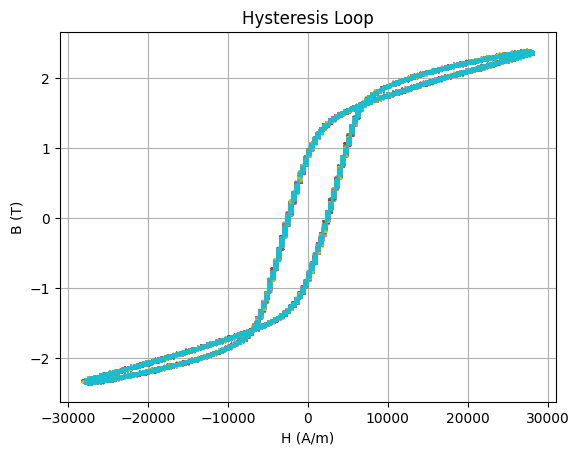

/tmp/ipykernel_2434/3938681461.py:263: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  loop_area = np.trapz(B_calc, H_calc)
/home/shani/physics report michaelmas/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
/home/shani/physics report michaelmas/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning: invalid value encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
/home/shani/physics report michaelmas/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1310: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/shani/physics report michaelmas/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1310: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 *

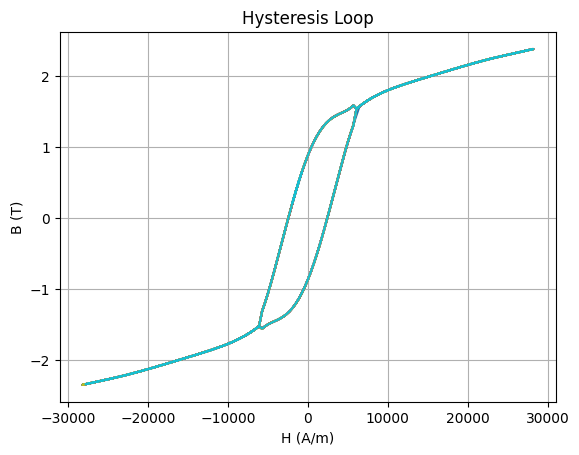

In [43]:
for i in range(20):
    sman = build_loop(split_hysteresis_loops(captures_3d[4])[i], "transformer_iron")
    plt.plot(sman[0],sman[1])
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("Hysteresis Loop")
plt.grid()
plt.show()

'''for i in range(20):
    sman = lin_reg_loop(-7000, 7000, build_loop(split_hysteresis_loops(captures_3d[4])[i], "transformer_iron"))
    plt.plot(sman[0],sman[1])
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("Hysteresis Loop")
plt.grid()
plt.show()'''

for i in range(20):
    sman = poly_reg_loop(build_loop(split_hysteresis_loops(captures_3d[4])[i], "transformer_iron"),-6000, 6000)
    plt.plot(sman[0],sman[1])
    #plt.errorbar(sman[0], sman[1], yerr=sman[2], fmt='o', markersize=2, alpha=0.3)
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("Hysteresis Loop")
plt.grid()
plt.show()


In [49]:
poly_reg_loop(build_loop(split_hysteresis_loops(capture_dic['capture6_3_2transformer_iron'])[0], "transformer_iron"),-6000, 6000)


/tmp/ipykernel_2434/3938681461.py:263: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  loop_area = np.trapz(B_calc, H_calc)
/home/shani/physics report michaelmas/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
/home/shani/physics report michaelmas/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning: invalid value encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
/home/shani/physics report michaelmas/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1310: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/shani/physics report michaelmas/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1310: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 *

(array([-4953.48095238, -4953.48095238, -4953.48095238, ...,
        -4572.67095238, -4572.67095238, -4572.67095238], shape=(39063,)),
 array([-1.04965694, -1.04965694, -1.04965694, ..., -0.9012083 ,
        -0.9012083 , -0.9012083 ], shape=(39063,)),
 array([0.00294769, 0.00294769, 0.00294769, ..., 0.04612758, 0.04612758,
        0.04612758], shape=(39063,)),
 {'H_range': np.float64(56024.73333333332),
  'B_range': np.float64(4.717277491490394),
  'loop_area': np.float64(-1507.8411278301792),
  'max_mu_r': np.float64(nan),
  'min_mu_r': np.float64(nan)})

In [46]:
capture_dic['capture6_3_2transformer_iron']

array([[-250.00089407, -250.00038207, -249.99987007, ...,  249.99985979,
         250.00037179,  250.00088379],
       [  -1.040231  ,   -1.040231  ,   -1.040231  , ...,    0.        ,
           0.        ,    0.        ],
       [  -0.3952079 ,   -0.3952079 ,   -0.3952079 , ...,    0.3398745 ,
           0.3398745 ,    0.3398745 ]], shape=(3, 976567))